# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [ ]:
#@author Reyhan Karamahmut

# Currently, there is an issue with loading the data. Please use the following workaround:

# 1. Download the data from
https://github.com/oduerr/ki/issues/2#issue-2359787187

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow import keras
import tensorflow as tf
from keras.utils import to_categorical 
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist
from emnist import extract_training_samples, extract_test_samples

from scipy.io import loadmat

In [44]:
def load_emnist_data():
    # Pfad zur entpackten Datei
    data_dir = "./emnist-matlab/matlab"
    mat_file_path = os.path.join(data_dir, 'emnist-balanced.mat')
    
    # Laden der .mat-Datei
    mat = loadmat(mat_file_path)
    
    # Extrahieren der Trainings- und Testdaten
    input_train = mat['dataset']['train'][0, 0]['images'][0, 0]
    target_train = mat['dataset']['train'][0, 0]['labels'][0, 0].flatten()
    input_test = mat['dataset']['test'][0, 0]['images'][0, 0]
    target_test = mat['dataset']['test'][0, 0]['labels'][0, 0].flatten()
    
    # Transformation der Daten
    input_train = input_train.reshape((input_train.shape[0], 28, 28), order="F")
    input_test = input_test.reshape((input_test.shape[0], 28, 28), order="F")
    
    return (input_train, target_train), (input_test, target_test)

In [45]:
# Vorbereiten von Nist
(input_train, target_train), (input_test, target_test) = load_emnist_data()

# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich
input_train = input_train[np.where(target_train <= 15)]
target_train = target_train[np.where(target_train <= 15)]
input_test = input_test[np.where(target_test <= 15)]
target_test = target_test[np.where(target_test <= 15)]
 
# Aufteilung in Trainings-, Validierungs- und Testdaten
X_val = input_train[0:8000] / 255
X_train = input_train[8000:] / 255
X_test = input_test / 255

Y_val = target_train[0:8000]
Y_train = target_train[8000:]
Y_test = target_test

del input_train, target_train, input_test, target_test

print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_val.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(30400, 28, 28)
(6400, 28, 28)
(8000,)
(30400,)
(6400,)


In [46]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"
X_val = np.reshape(X_val, (X_val.shape[0],28,28,1))
X_train = np.reshape(X_train, (X_train.shape[0],28,28,1))
X_test = np.reshape(X_test, (X_test.shape[0],28,28,1))

# Labels in One-Hot-Kodierung umwandeln
Y_val = keras.utils.to_categorical(Y_val, 16)
Y_train = keras.utils.to_categorical(Y_train, 16)
Y_test = keras.utils.to_categorical(Y_test, 16)

# print(X_val.shape)
# print(X_train.shape)
# print(X_test.shape)
# print(Y_val.shape)
# print(Y_train.shape)
# print(Y_test.shape)

(8000, 28, 28, 1)
(30400, 28, 28, 1)
(6400, 28, 28, 1)
(8000, 16)
(30400, 16)
(6400, 16)


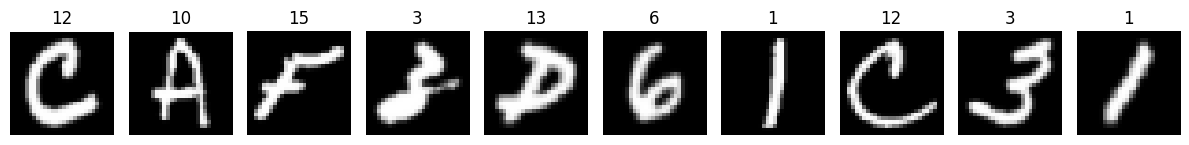

In [47]:
# Plotten Sie hier ein paar Ziffern!
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title(str(np.argmax(Y_train,axis=1)[i]))
    plt.axis('off')
    plt.tight_layout() 

In [60]:
# Laden des Modells
base_model = tf.keras.models.load_model("../exercise_2/CNN")

#Hier die letzte Schicht entfernen
base_model.pop()

In [61]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
Total params: 18816 (73.50 KB)
Trainable params: 18816

In [50]:
# Modell einfrieren
for layer in base_model.layers:
    layer.trainable =False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
last_layer = tf.keras.layers.Dense(16)(x)
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)

In [57]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [58]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 1600)              18816     
                                                                 
 dense_2 (Dense)             (None, 16)                25616     
                                                                 
 activation_2 (Activation)   (None, 16)                0         
                                                                 
Total params: 44432 (173.56 KB)
Trainable params: 25616 (100.06 KB)
Non-trainable params: 18816 (73.50 KB)
_________________________________________________________________


In [59]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = X_test, y = Y_test)

200/200 [==============================] - 1s 5ms/step - loss: 0.2586 - accuracy: 0.9350


In [53]:
# Hier das Netzwerk für 10 Epochen trainieren!
epochs = 10
history=model.fit(X_train, Y_train,
                  batch_size=128,
                  epochs=epochs,
                  verbose=2,
                  validation_data=(X_val, Y_val)
                  )

Epoch 1/10


2024-06-17 11:46:21.702446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95334400 exceeds 10% of free system memory.


238/238 - 5s - loss: 1.7823 - accuracy: 0.5915 - val_loss: 1.0893 - val_accuracy: 0.8055 - 5s/epoch - 21ms/step
Epoch 2/10
238/238 - 5s - loss: 0.8530 - accuracy: 0.8338 - val_loss: 0.6866 - val_accuracy: 0.8589 - 5s/epoch - 20ms/step
Epoch 3/10
238/238 - 5s - loss: 0.6005 - accuracy: 0.8720 - val_loss: 0.5274 - val_accuracy: 0.8821 - 5s/epoch - 20ms/step
Epoch 4/10
238/238 - 5s - loss: 0.4835 - accuracy: 0.8898 - val_loss: 0.4419 - val_accuracy: 0.8959 - 5s/epoch - 21ms/step
Epoch 5/10
238/238 - 5s - loss: 0.4133 - accuracy: 0.9028 - val_loss: 0.3844 - val_accuracy: 0.9096 - 5s/epoch - 19ms/step
Epoch 6/10
238/238 - 5s - loss: 0.3652 - accuracy: 0.9133 - val_loss: 0.3438 - val_accuracy: 0.9164 - 5s/epoch - 20ms/step
Epoch 7/10
238/238 - 5s - loss: 0.3306 - accuracy: 0.9190 - val_loss: 0.3128 - val_accuracy: 0.9246 - 5s/epoch - 20ms/step
Epoch 8/10
238/238 - 5s - loss: 0.3028 - accuracy: 0.9245 - val_loss: 0.2890 - val_accuracy: 0.9296 - 5s/epoch - 19ms/step
Epoch 9/10
238/238 - 5s - l

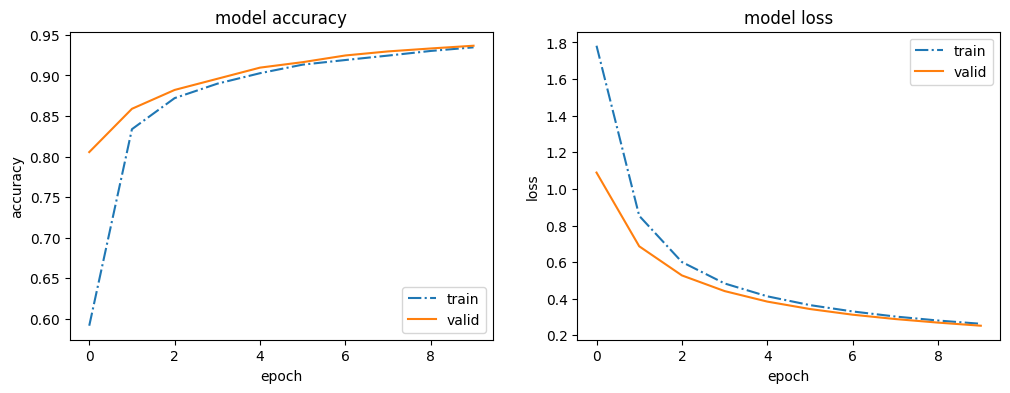

In [54]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [56]:
# Confusion Matrix erstellen
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

200/200 [==============================] - 1s 6ms/step
[[366   1   0   0   1   0   2   0   0   0   3   0   3  24   0   0]
 [  0 391   3   0   1   1   0   1   0   0   1   0   0   0   0   2]
 [  4   0 381   2   1   0   0   1   3   0   1   1   2   4   0   0]
 [  3   0   1 382   1   3   0   1   1   3   0   5   0   0   0   0]
 [  1   0   1   0 369   0   1   0   0  10  10   1   0   1   0   6]
 [  1   0   2   6   1 371   2   1   0   3   0   0   5   0   6   2]
 [  0   2   1   0   0   1 391   0   0   0   0   1   3   0   0   1]
 [  1   1   2   1   1   0   0 386   0   4   0   0   0   0   0   4]
 [  1   3   1   3   2   3   0   0 341   7   0  27   2   1   6   3]
 [  0   0   1   1   5   1   0   9   2 380   0   0   1   0   0   0]
 [  1   1   2   0   5   0   0   0   0   1 382   3   0   2   2   1]
 [  6   2   1   3   0   1   1   2  10   0   7 356   1   3   6   1]
 [  9   0   2   0   1   0   4   0   0   0   0   2 380   0   1   1]
 [ 24   2   5   4   1   0   0   1   0   0   6   2   0 355   0   0]
 [  0  